In [136]:
import keras
import numpy as np
import tensorflow as tf
import matplotlib as mpl
from PIL import Image
import matplotlib.pyplot as plt

In [137]:
model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [ ]:
# process the image
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

In [ ]:
image_path = r'your image path'
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [140]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

In [141]:
# Get the input label of the image.
labrador_retriever_index = 41
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)

In [142]:
epsilon = 0.3
description = f"Epsilon = {epsilon:.2f}"

# Generate adversarial image
adv_x = image + epsilon * perturbations
adv_x = tf.clip_by_value(adv_x, -1, 1)

# Predict label
pred = model(adv_x)
label = get_imagenet_label(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


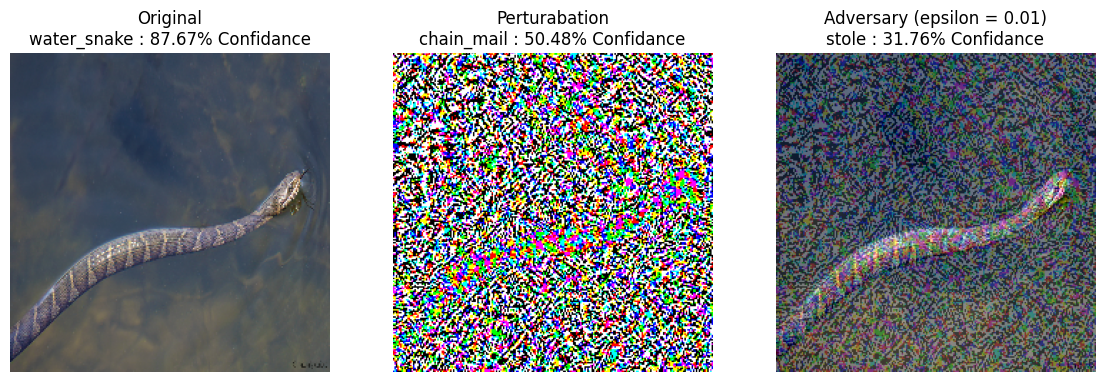

In [143]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.imshow(image[0] * 0.5 + 0.5) # To change [-1, 1] to [0,1]
_, image_class, class_confidance = get_imagenet_label(image_probs)
plt.title('Original\n{} : {:.2f}% Confidance'.format(image_class, class_confidance*100))
plt.axis('off')


plt.subplot(1, 3, 2)
plt.imshow(perturbations[0] * 0.5 + 0.5)
_, image_class, class_confidance = get_imagenet_label(model.predict(perturbations))
plt.title('Perturabation\n{} : {:.2f}% Confidance'.format(image_class, class_confidance*100))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(adv_x[0] * 0.5 + 0.5)
_, image_class, class_confidance = get_imagenet_label(model.predict(adv_x))
plt.title('Adversary (epsilon = 0.01)\n{} : {:.2f}% Confidance'.format(image_class, class_confidance*100))
plt.axis('off')

plt.show()
plt.close()

In [144]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(model.inputs, [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [145]:
model.layers[-1].activation = None

In [146]:
model.layers[-1].activation

In [147]:
def save_and_display_gradcam(img_tensor, heatmap, alpha=0.4):
    img = img_tensor[0].numpy()                 # shape: (224, 224, 3), range [-1, 1]
    img = (img + 1.0) / 2.0                      # scale to [0, 1]
    img = np.uint8(255 * img)                   # scale to [0, 255]

    # Rescale heatmap to [0, 255]
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap
    jet = mpl.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]     # shape: (256, 3)
    jet_heatmap = jet_colors[heatmap]           # shape: (H, W, 3), still float32 in [0, 1]

    # Resize heatmap directly using PIL (more accurate resizing)
    heatmap_img = Image.fromarray(np.uint8(jet_heatmap * 255))
    heatmap_img = heatmap_img.resize((img.shape[1], img.shape[0]), resample=Image.BILINEAR)
    jet_heatmap = np.array(heatmap_img)         # shape: (H, W, 3), dtype: uint8

    # Superimpose
    superimposed_img = jet_heatmap * alpha + img * (1 - alpha)
    superimposed_img = np.uint8(superimposed_img)

    return superimposed_img

In [148]:
def interpolate_images(baseline, image, alphas):
    baseline = tf.cast(baseline, tf.float32)
    image = tf.cast(image, tf.float32)
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    return baseline + alphas_x * (image - baseline)

In [149]:
def integral_approximation(gradients):
    grads = (gradients[:-1] + gradients[1:]) / 2.0
    return tf.reduce_mean(grads, axis=0)

In [150]:
@tf.function
def compute_gradients(images, target_class_idx, model):
    with tf.GradientTape() as tape:
        tape.watch(images)
        logits = model(images)
        if len(logits.shape) == 1:
            logits = tf.expand_dims(logits, axis=0)
        probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
    grads = tape.gradient(probs, images)
    return grads

In [ ]:


def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         model,
                         m_steps=50,
                         batch_size=32):
    
    # 1. Generate alphas (interpolation coefficients)
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps + 1)

    # 2. Collect gradients across batches
    gradient_batches = []
    for i in range(0, len(alphas), batch_size):
        alpha_batch = alphas[i:i + batch_size]
        interpolated_batch = interpolate_images(baseline, image, alpha_batch)
        grads = compute_gradients(interpolated_batch, target_class_idx, model)
        gradient_batches.append(grads)

    # 3. Combine gradient batches
    total_gradients = tf.concat(gradient_batches, axis=0)

    # 4. Approximate integral (Riemann trapezoidal rule)
    avg_gradients = integral_approximation(total_gradients)

    # 5. Scale by input difference
    integrated_grads = (image - baseline) * avg_gradients

    return integrated_grads


In [152]:
@tf.function
def one_batch(baseline, image, alpha_batch, target_class_idx):
    # Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)
    return gradient_batch

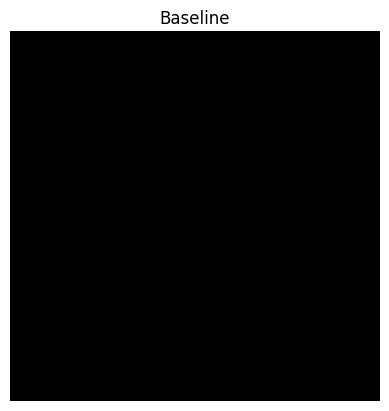

In [153]:
baseline = tf.zeros(shape=(224,224,3))
plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()

In [154]:
ig_attributions = integrated_gradients(
    baseline=baseline, 
    image=image, 
    target_class_idx=48,
    model=model,
    m_steps=240
)

In [155]:
print(ig_attributions.shape)

(1, 224, 224, 3)


In [156]:
def generate_attribution_mask(baseline,
                               image,
                               target_class_idx,
                               model,
                               m_steps=50):
    attributions = integrated_gradients(
        baseline=baseline,
        image=image,
        target_class_idx=target_class_idx,
        model=model,
        m_steps=m_steps
    )
    
    attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)
    return attribution_mask


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


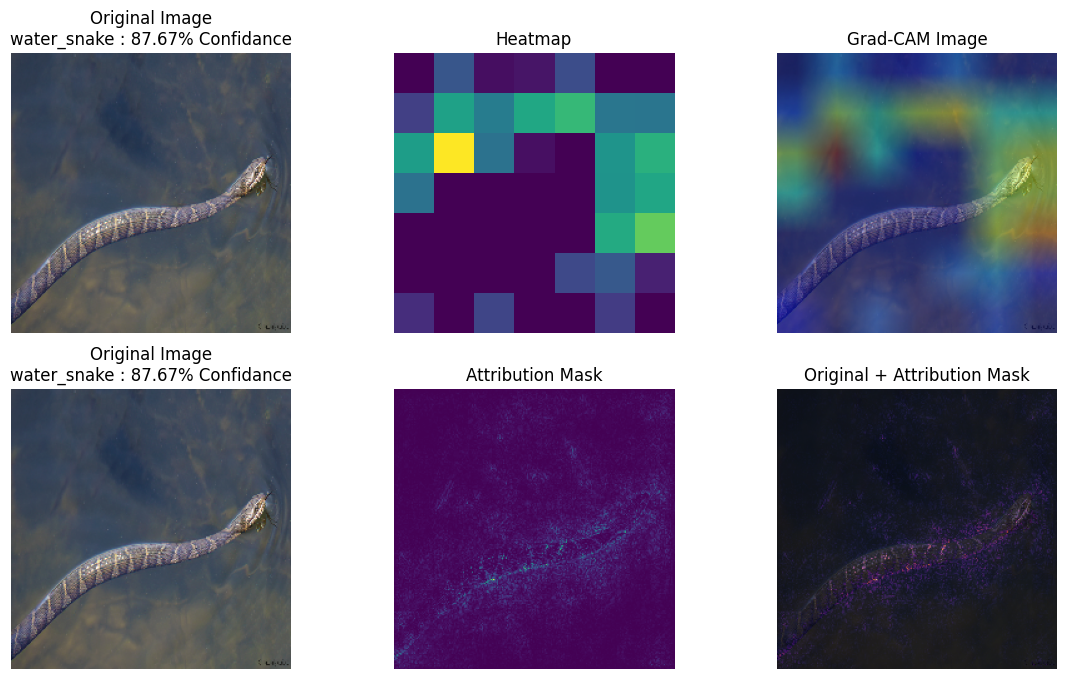

In [157]:
plt.figure(figsize=(14, 8))

plt.subplot(2, 3, 1)
plt.imshow(image[0] * 0.5 + 0.5)
_, image_class, class_confidance = get_imagenet_label(model.predict(image))
plt.title('Original Image\n{} : {:.2f}% Confidance'.format(image_class, class_confidance*100))
plt.axis('off')

plt.subplot(2, 3, 2)
heatmap_original = make_gradcam_heatmap(img_array=image, model=model, last_conv_layer_name='Conv_1', pred_index=41)
plt.imshow(heatmap_original * 0.5 + 0.5)
plt.title("Heatmap")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(save_and_display_gradcam(image, heatmap_original))
plt.title("Grad-CAM Image")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(image[0] * 0.5 + 0.5)
_, image_class, class_confidance = get_imagenet_label(model.predict(image))
plt.title('Original Image\n{} : {:.2f}% Confidance'.format(image_class, class_confidance*100))
plt.axis('off')

plt.subplot(2, 3, 5)
attribution_mask = generate_attribution_mask(
    image=image[0],
    baseline=baseline,
    target_class_idx=41,
    model=model,  # ✅ your ResNet or other model
    m_steps=240
)
plt.imshow(attribution_mask * 0.5 + 0.5)
plt.title('Attribution Mask')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(attribution_mask * 0.5 + 0.5, cmap=plt.cm.inferno)
plt.imshow(image[0] * 0.5 + 0.5, alpha=0.3, cmap=plt.cm.inferno)
plt.title("Original + Attribution Mask")
plt.axis('off')

plt.show()
plt.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


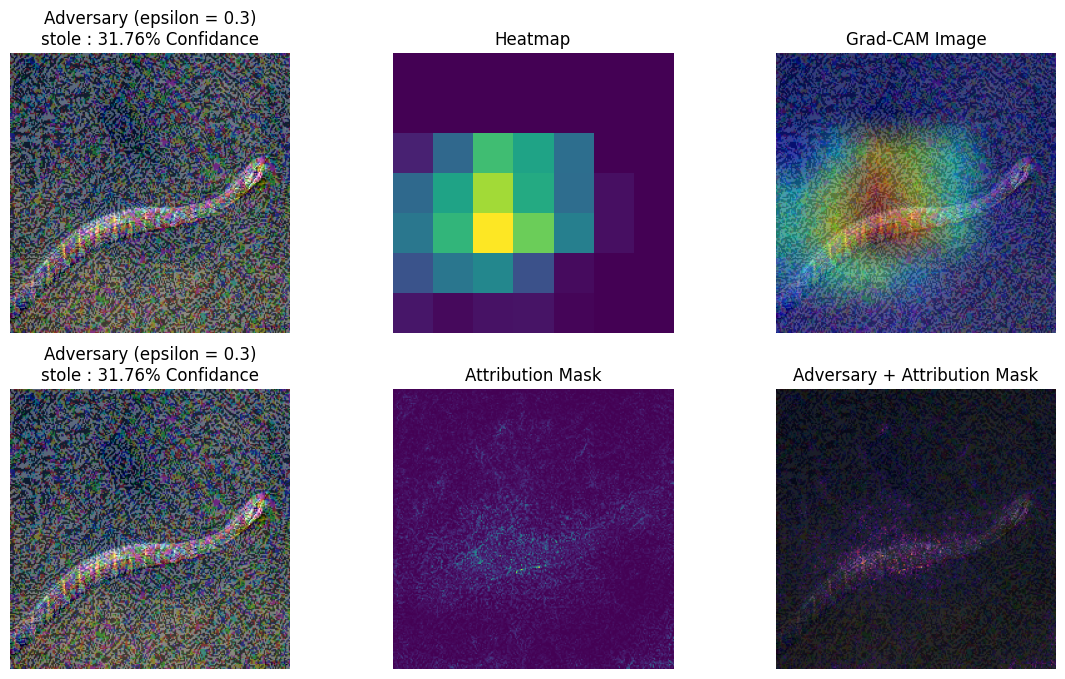

In [162]:
plt.figure(figsize=(14, 8))

plt.subplot(2, 3, 1)
plt.imshow(adv_x[0] * 0.5 + 0.5)
_, image_class, class_confidance = get_imagenet_label(model.predict(adv_x))
plt.title('Adversary (epsilon = 0.3)\n{} : {:.2f}% Confidance'.format(image_class, class_confidance*100))
plt.axis('off')

plt.subplot(2, 3, 2)
heatmap = make_gradcam_heatmap(img_array=adv_x, model=model, last_conv_layer_name='Conv_1', pred_index=48)
plt.imshow(heatmap * 0.5 + 0.5)
plt.title("Heatmap")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(save_and_display_gradcam(adv_x, heatmap))
plt.title("Grad-CAM Image")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(adv_x[0] * 0.5 + 0.5)
_, image_class, class_confidance = get_imagenet_label(model.predict(adv_x))
plt.title('Adversary (epsilon = 0.3)\n{} : {:.2f}% Confidance'.format(image_class, class_confidance*100))
plt.axis('off')

plt.subplot(2, 3, 5)
attribution_mask = generate_attribution_mask(
    image=adv_x[0],                # Your adversarial image
    baseline=baseline,             # Your baseline image (e.g., black or blurred)
    target_class_idx=48,           # The class you’re explaining
    model=model,                   # Your pretrained model (e.g., ResNet50)
    m_steps=240                    # Number of integration steps
)

plt.imshow(attribution_mask * 0.5 + 0.5)
plt.title('Attribution Mask')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(attribution_mask * 0.5 + 0.5, cmap=plt.cm.inferno)
plt.imshow(adv_x[0] * 0.5 + 0.5, alpha=0.3, cmap=plt.cm.inferno)
plt.title("Adversary + Attribution Mask")
plt.axis('off')

plt.show()
plt.close()

In [159]:
base_model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
base_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [160]:
base_model.layers[-1].activation

<function keras.src.activations.activations.softmax(x, axis=-1)>

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


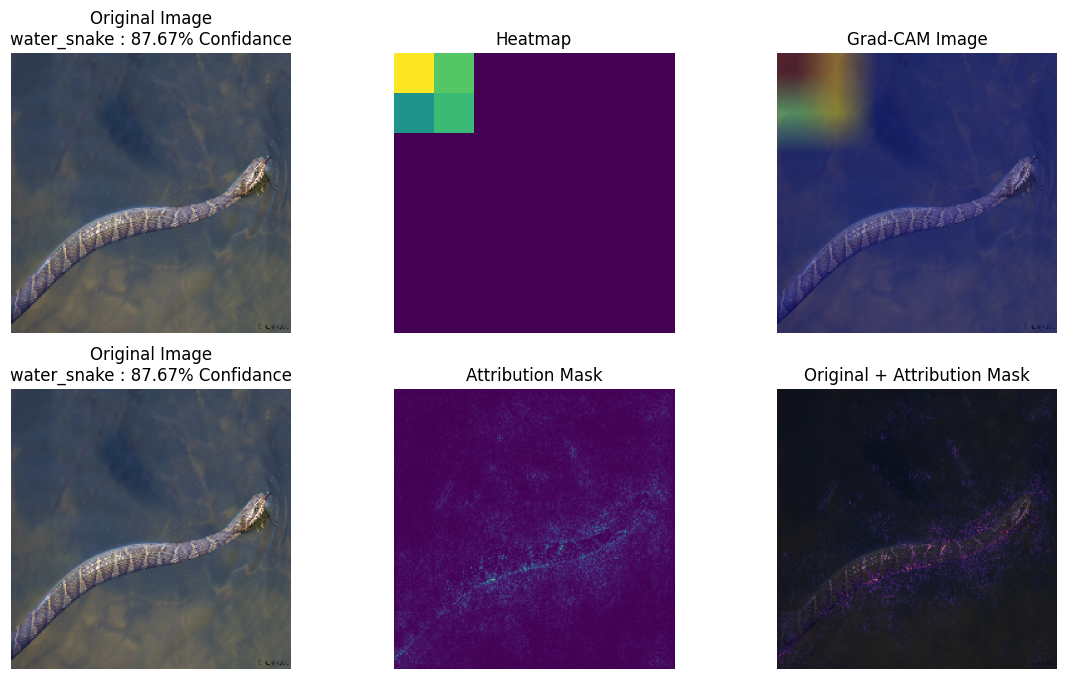

In [161]:
plt.figure(figsize=(14, 8))

plt.subplot(2, 3, 1)
plt.imshow(image[0] * 0.5 + 0.5)
_, image_class, class_confidance = get_imagenet_label(base_model.predict(image))
plt.title('Original Image\n{} : {:.2f}% Confidance'.format(image_class, class_confidance*100))
plt.axis('off')

plt.subplot(2, 3, 2)
heatmap_original = make_gradcam_heatmap(img_array=image, model=base_model, last_conv_layer_name='Conv_1', pred_index=41)
plt.imshow(heatmap_original * 0.5 + 0.5)
plt.title("Heatmap")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(save_and_display_gradcam(image, heatmap_original))
plt.title("Grad-CAM Image")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(image[0] * 0.5 + 0.5)
_, image_class, class_confidance = get_imagenet_label(base_model.predict(image))
plt.title('Original Image\n{} : {:.2f}% Confidance'.format(image_class, class_confidance*100))
plt.axis('off')

plt.subplot(2, 3, 5)
attribution_mask = generate_attribution_mask(
    image=image[0],               # Input image (shape: [H, W, C])
    baseline=baseline,            # Baseline image (same shape)
    target_class_idx=41,          # Class index to explain
    model=model,                  # Your pretrained model
    m_steps=240                   # Number of integration steps
)
plt.imshow(attribution_mask * 0.5 + 0.5)
plt.title('Attribution Mask')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(attribution_mask * 0.5 + 0.5, cmap=plt.cm.inferno)
plt.imshow(image[0] * 0.5 + 0.5, alpha=0.3, cmap=plt.cm.inferno)
plt.title("Original + Attribution Mask")
plt.axis('off')

plt.show()
plt.close()